# Segmenting nerves

In [1]:
import numpy as np
from skimage import io
import matplotlib.pyplot as plt

# import the volume
im = io.imread('nerves_part.tiff').astype(np.float32)
print(im.shape)

(1024, 350, 350)


In [105]:
%run helper_functions.py

All helper functions loaded.


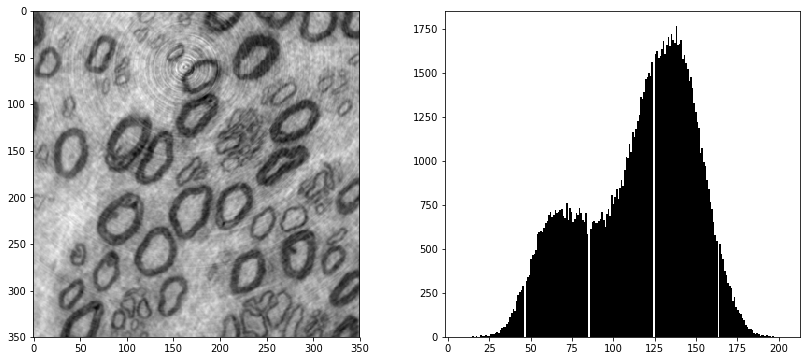

In [3]:
# let's start by looking at a single image
img = im[0]

# invert and scale to values between 0.0 and 1.0
from skimage.util import invert
inv = invert(img/255)

f, ax = plt.subplots(ncols=2, figsize=(14,6))
ax[0].imshow(img, cmap='gray'); # inverted
ax[1].hist(img.ravel(), bins=200, color='k');

## Thresholding and Markov Random Field

In [4]:
import scipy
import maxflow

# thresholding based on histogram
img_th = img<90

# Create the graph.
g = maxflow.Graph[float]()

# make each pixel of the image a (consecutively labeled) node
nodes = g.add_grid_nodes(inv.shape)

# Non-terminal edges have the same capacity as the nodes
g.add_grid_edges(nodes, 0.8) # beta = 0.8 seems to work well on this
g.add_grid_tedges(nodes, img_th, 1.2-img_th) # terminal edges

# Compute max. flow through the constructed graph
g.maxflow()
    
# Get the segments of the nodes in the grid.
# Their labels are 1 where sgm is False and 0 otherwise.
sgm = g.get_grid_segments(nodes)
# save the segmented image    
binaryimg = np.int_(np.logical_not(sgm))


f, ax = plt.subplots(figsize = (14,6), ncols=2)
ax[0].imshow(img_th, cmap='gray');
ax[0].set(title='Image thresholded at 90', xticks=[], yticks=[])
ax[1].imshow(binaryimg);
ax[1].set(title=('MRF segmentation (edge capacities: beta = 0.8)'),
                            xticks=[], yticks=[]);

ModuleNotFoundError: No module named 'maxflow'

### Fitting a deformable model to a well separated nerve cell
Let's first look at a small fraction of the image. We'll initialize a circular snake at the center of the nerve and iteratively update its shape by consecutively calling `updateCurve` (see *helper_functions.py*) on it.

In [5]:
testnerve = binaryimg[40:100, 150:210]
h,w = testnerve.shape
snakepoints = 40

Snake = InitSnake((h/2,w/2), h/4, snakepoints)

B = SmoothKernel(Snake, 0.9, 0.7)

Snake_tmp = updateCurve(testnerve, Snake, B)

f, ax = plt.subplots(ncols=5, figsize=(20,6))

for i in range(21):
    
    Snake_tmp = updateCurve(testnerve, Snake_tmp, B)
    
    if i%5 == 0:
        j = int(i/5)
        if i == 0:
            ax[j].imshow(testnerve, cmap = 'gray')
            ax[j].plot(Snake[0,:], Snake[1,:], color = 'r', linewidth = 5);
            ax[j].set(title='Initialized snake', xticks=[], yticks=[])
        else:
            ax[j].imshow(testnerve, cmap = 'gray');
            ax[j].plot(Snake_tmp[0,:], Snake_tmp[1,:], color = 'r', linewidth = 5);
            ax[j].set(title='Iteration '+str(i), xticks=[], yticks=[])

NameError: name 'binaryimg' is not defined

In [6]:
# let's first look at a small fraction of the image
nerve2 = binaryimg[280:340, 120:180]
nerve3 = binaryimg[200:260, 215:275]
nerve4 = binaryimg[200:260, 220:280]

h,w = nerve2.shape


snakepoints = 40
Snake = InitSnake((h/2,w/2), h/4, snakepoints)

B = SmoothKernel(Snake, 0.9, 0.7)

f, ax = plt.subplots(ncols=3, figsize=(16,5))

ax[0].imshow(nerve2, cmap = 'gray');
ax[0].axis("off");

Snake_tmp = updateCurve(nerve2, Snake, B)
# iteratively update the fitted curve:
for i in range(40):
    Snake_tmp = updateCurve(nerve2, Snake_tmp, B)
    
ax[0].plot(Snake_tmp[0,:], Snake_tmp[1,:], color = 'r', linewidth = 5);

ax[1].imshow(nerve3, cmap = 'gray');
ax[1].axis("off");

Snake_tmp3 = updateCurve(nerve3, Snake, B)
# iteratively update the fitted curve:
for j in range(40):
    Snake_tmp3 = updateCurve(nerve3, Snake_tmp3, B)
    
ax[1].plot(Snake_tmp3[0,:], Snake_tmp3[1,:], color = 'r', linewidth = 5);


ax[2].imshow(nerve4, cmap = 'gray');
ax[2].axis("off");

Snake_tmp4 = updateCurve(nerve4, Snake, B)
# iteratively update the fitted curve:
for j in range(40):
    Snake_tmp4 = updateCurve(nerve4, Snake_tmp4, B)
    
ax[2].plot(Snake_tmp4[0,:], Snake_tmp4[1,:], color = 'r', linewidth = 5);

NameError: name 'binaryimg' is not defined

In general, this approach seems to work well for cells that are properly segmented. However, the __initialization of the snake turns out to be cruicial.__ The plot above shows proper convergence in the left and middle image segment. Performance decreases however, if the snake is not initialized in the center of the cell, as shown on the right.

# Next... Blob detection?

Apply the Determinant Of Hessians to the image to find the centers and radii of the different snakes. From the histogram, we estimate the grey background to have a value of around 140.


(0, 3)


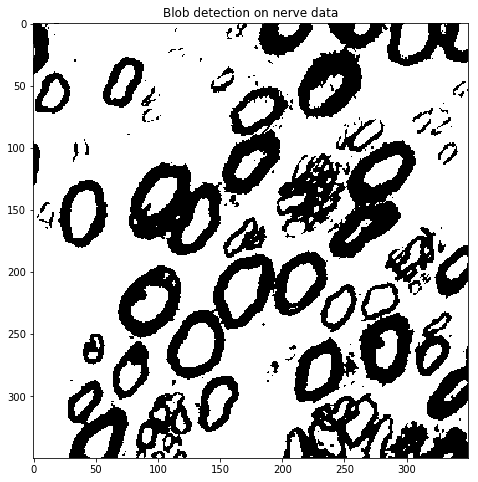

In [116]:
img = im[0]
img = img > 100
blobs_doh = blob_doh(img.astype(float), min_sigma=5, max_sigma=30, num_sigma=10, threshold=0.1, overlap=0.1, log_scale=False)
f, ax = plt.subplots(figsize=(8,8))
ax.imshow(img, cmap = 'gray')
ax.set(title=('Blob detection on nerve data'));
for blob in blobs_doh:
        y, x, r = blob
        c = plt.Circle((x, y), r, color='red', linewidth=2, fill=False)
        ax.add_patch(c)

print(blobs_doh.shape)

This clearly does not work.

# Making volumetric data

In [ ]:
# Load the latest Snake function:
def DeformeableModel(im, curve, alpha, beta, stepsize, maxiter):
    l = curve.shape[0]

    # 0. Make the smoothing kernel once
    B = np.zeros((l,l))

    # Kernel for minimum length
    Lml = -2*np.identity(l, dtype = None).astype(np.int); 
    Lml += np.roll(np.identity(l, dtype = None).astype(np.int),1,axis = 0)
    Lml += np.roll(np.identity(l, dtype = None).astype(np.int),-1,axis = 0)
    # Kernel for minimum curvature
    Lmc = -6*np.identity(l, dtype = None).astype(np.int); 
    Lmc += np.roll(-np.identity(l, dtype = None).astype(np.int),2,axis = 0)
    Lmc += np.roll(-np.identity(l, dtype = None).astype(np.int),-2,axis = 0)
    Lmc += np.roll(4*np.identity(l, dtype = None).astype(np.int),1,axis = 0)
    Lmc += np.roll(4*np.identity(l, dtype = None).astype(np.int),-1,axis = 0)
    # Apply formulae from the course note
    I = np.identity(l, dtype = None).astype(np.int)
    B = np.linalg.inv(I - alpha*Lml - beta*Lmc)
    
    for iteration in range(maxiter):
        # 1. Find Region Of Interest and its inverse mask (= Snake curve interior and exterior area) 
        ROI = []; notROI = []
        # Make set of all image indices:
        i,j = np.indices(im.shape)
        indices = np.asarray([i.flatten(),j.flatten()]) 
        # Divide set of indices into ROI (= inside polygon) or notROI (= outside polygon)
        truth = skimage.measure.points_in_poly(indices.T, curve)
        x = np.where(truth == True)
        ROI.append([indices[0, x], indices[1, x]])
        x = np.where(truth == False)
        notROI.append([indices[0, x], indices[1, x]])
        ROI = np.asarray(ROI)
        notROI = np.asarray(notROI)
    
        # 2. Compute bilinear interpolaten of the Snake curve:
        I = np.zeros((l,1))
        x0 = np.floor(curve[:,0]).astype(np.int)
        x1 = np.ceil(curve[:,0]).astype(np.int)
        y0 = np.floor(curve[:,1]).astype(np.int)
        y1 = np.ceil(curve[:,1]).astype(np.int)
        dx = curve[:,0] - x0
        dy = curve[:,1] - y0
        I[:,0] = im[y0,x0]*(1 - dx)*(1 - dy) + im[y0,x1]*dx*(1 - dy) + im[y1,x0]*(1 - dx)*dy + im[y1,x1]*dx*dy

        # 3. Using these Regions Of Interest, compute the magnitude (scalar value) of the Snake displacement:
        # Fext =(m_in − m_out)*(2*I − m_in − m_out)*N
        # Find mean intensities as before with ROI:
        m_in  = np.mean(im[ROI])
        m_out = np.mean(im[notROI])
        F = (m_in - m_out)*(2*I - m_in - m_out)

        # 4. Find normal vectors of the Snake curve:
        NormVecs = np.zeros((l,2))
        TangVecs = np.zeros((l,2))
        # Calculate tangent vectors with finite dfference
        TangVecs =  np.roll(curve,-1, axis = 0) - np.roll(curve,1, axis = 0)
        TangVecs[-1,:] = TangVecs[0,:]
        # Normalize lengths
        lengths = (TangVecs[:,0]**2 + TangVecs[:,1]**2)**0.5
        TangVecs[:,0] = TangVecs[:,0]/lengths
        TangVecs[:,1] = TangVecs[:,1]/lengths
        # Compute normal as a 90 degree rotation
        NormVecs[:,0] = TangVecs[:,1]
        NormVecs[:,1] = -TangVecs[:,0]
        # Multiply with correct lengths
        NormVecs = np.multiply(NormVecs, F)

        # 5. Update the curve
        if isinstance(stepsize, int):
            step = stepsize
        else:
            step = stepsize[iteration]
        curve = B@(curve + step*NormVecs)
        # Redistribute the points evenly
        Dist = (((curve[:,0] - np.roll(curve[:,0],-1))**2 + (curve[:,1] - np.roll(curve[:,1],-1))**2)**0.5)
        correctDist = np.linspace(0,np.sum(Dist),l)
        interpol = scipy.interpolate.interp1d(np.cumsum(Dist), curve[:,0], fill_value="extrapolate")
        curve[:,0] = interpol(correctDist)
        interpol = scipy.interpolate.interp1d(np.cumsum(Dist), curve[:,1], fill_value="extrapolate")
        curve[:,1] = interpol(correctDist)
        # Close the curve
        curve[-1,:] = curve[0,:]
    return curve

In [117]:
Square = skimage.color.rgb2gray(skimage.io.imread("TestImageSimple.png")).astype(np.int);
Snake = InitSnake((150,100), 75, 200)
B = SmoothKernel(Snake, 0.5, 0.9)
print(Snake.shape)

(2, 200, 51)
(2, 200)


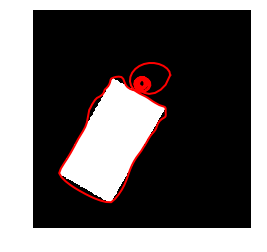

In [34]:
# Save the iteration step as the 'third' dimension
maxiter = 50
stepsize = np.linspace(50,10,maxiter)

VolData = np.zeros((Snake.shape[0], Snake.shape[1], maxiter + 1))
NewSnake = updateCurve(Square, Snake, B)
VolData[:,:,0] = Snake
VolData[:,:,1] = NewSnake

for i in range(2,maxiter):
    NewSnake = updateCurve(Square, NewSnake, B)
    VolData[:,:,i] = NewSnake 
print(VolData.shape)
print(Snake.shape)



plt.imshow(Square, cmap = 'gray');
plt.axis("off");
plt.plot(NewSnake[0,:], NewSnake[1,:], color = 'r', linewidth = 2);

(1, 200)


TypeError: Length of y must be number of rows in z.

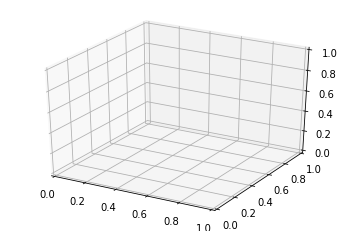

In [40]:
from mpl_toolkits import mplot3d

fig = plt.figure()
ax = plt.axes(projection='3d')

# Data for three-dimensional scattered points
for i in range(maxiter):
    ax.contour3D(VolData[0,:,i], VolData[1,:,i], np.ones((2,Snake.shape[1]))*i, cmap='viridis');
    ax.view_init(45, 35)


In [42]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

for i in range(1,maxiter):
    Axes3D.plot_trisurf(VolData[0,:,i], VolData[1,:,i], np.ones((2,Snake.shape[1]))*i);
    #ax.view_init(45, 35)

AttributeError: 'numpy.ndarray' object has no attribute 'has_data'

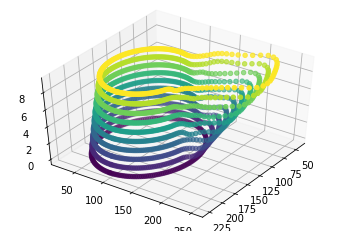

In [119]:
# Copy from above:
Square = skimage.color.rgb2gray(skimage.io.imread("TestImageSimple.png")).astype(np.int);
Snake = InitSnake((150,100), 75, 200)
B = SmoothKernel(Snake, 0.5, 0.9)

maxiter = 10
NewSnake = updateCurve(Square, Snake, B)

VolData = np.zeros((3, Snake.shape[1]*maxiter))

tempX = list(Snake[0,:])
tempX += NewSnake[0,:].tolist()

tempY = list(Snake[1,:])
tempY += NewSnake[1,:].tolist()

tempZ = [0]*Snake.shape[1]
tempZ += [1]*Snake.shape[1]

for i in range(2,maxiter):
    NewSnake = updateCurve(Square, NewSnake, B)
    tempX += NewSnake[0,:].tolist()
    tempY += NewSnake[1,:].tolist()
    tempZ += [i]*Snake.shape[1]

VolData[0,:] = np.asarray(tempX)
VolData[1,:] = np.asarray(tempY)
VolData[2,:] = np.asarray(tempZ)

from mpl_toolkits import mplot3d
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(VolData[0,:], VolData[1,:], VolData[2,:], c=VolData[2,:], cmap='viridis' );
ax.view_init(45, 35)


